## UPLOAD RAW DATA TO GCS BUCKET 

In [3]:
import os
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi
import datetime
from google.cloud import storage
from google.oauth2 import service_account

def download_dataset(dataset_path):
    """
    Downloads a dataset from Kaggle, unzips it, and saves it to a local directory.
    
    Args:
    dataset_path (str): The path on Kaggle where the dataset is located (e.g., 'username/dataset-name').
    
    The function will create a folder in the current working directory named 'dataset',
    download the zip file there, extract its contents, and then delete the zip file.
    """
    # Initialize the Kaggle API and authenticate the user
    api = KaggleApi()
    api.authenticate()
    
    # Create the directory for the dataset if it doesn't already exist
    dataset_folder = './dataset'
    if not os.path.exists(dataset_folder):
        os.makedirs(dataset_folder)

    # Construct the path for the zip file in the local directory
    zip_filename = f"{dataset_path.split('/')[-1]}.zip"
    zip_filepath = os.path.join(dataset_folder, zip_filename)

    # Download the dataset zip file from Kaggle to the specified local directory
    api.dataset_download_files(dataset_path, path=dataset_folder, unzip=False)

    # Unzip the dataset file
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(dataset_folder)

    # Delete the zip file after extraction to clean up
    os.remove(zip_filepath)

    # Print confirmation that the dataset has been downloaded and saved
    print(f'Dataset downloaded and saved in {dataset_folder}')

In [4]:
download_dataset('curiel/rtechnology-posts-and-comments')

Dataset URL: https://www.kaggle.com/datasets/curiel/rtechnology-posts-and-comments
Dataset downloaded and saved in ./dataset


In [5]:
# Defining the method to upload to gcs bucket
def upload_to_gcs(bucket_name, blob_prefix, local_directory='./'):
    """
    Uploads a file to a Google Cloud Storage bucket.
    
    Args:
    bucket_name (str): Name of the GCS bucket.
    blob_prefix (str): Path prefix in the bucket where the file will be stored.
    local_directory (str): Local directory path where the file is located.
    """
    # Path to your service account key file
    service_account_path = 'gc_key.json'

    # Create a credentials object from the service account file
    credentials = service_account.Credentials.from_service_account_file(service_account_path)

    # Initialize a Google Cloud Storage client with the credentials
    storage_client = storage.Client(credentials=credentials)
    bucket = storage_client.bucket(bucket_name)

    # Generate today's date to construct the file name
    today = datetime.datetime.now().strftime('%Y-%m-%d')
    local_file = f'data_{today}.csv'
    local_file_path = os.path.join(local_directory, local_file)

    # Check if the file exists before uploading
    if not os.path.exists(local_file_path):
        print(f"Error: The file {local_file_path} does not exist.")
        return

    # Define the blob (file) path in the bucket
    blob_path = os.path.join(blob_prefix, local_file)
    blob = bucket.blob(blob_path)

    # Upload the file
    blob.upload_from_filename(local_file_path)
    print(f"Uploaded {local_file} to {blob_path}")

# Example usage:
bucket_name = 'technology_subreddit'
blob_prefix = 'tech_data'

# Call the function to upload the file
upload_to_gcs(bucket_name, blob_prefix)


## DATA PREPROCESSING AND TRANSFORMATION

###  IMPORT SPARK 

In [6]:
# Initializes findspark, a library that makes it easier to find and use Apache Spark in Python environments.
import findspark
findspark.init()

### IMPORT LIBRARIRES

In [58]:
from pyspark.sql import SparkSession  # Main entry point for DataFrame and SQL functionality in PySpark
from pyspark.sql import functions as F  # Importing PySpark functions with an alias F for easier access
from pyspark.sql.types import StringType, ArrayType, IntegerType  # Data types for defining DataFrame schemas in PySpark
from pyspark.ml import Pipeline  # Allows for the creation of a series of transformation steps for data processing
from pyspark.ml.feature import Tokenizer, StopWordsRemover, NGram, Tokenizer  # Text processing classes for NLP tasks
from pyspark.sql.functions import (  # Collection of functions for DataFrame transformations and manipulations
    to_timestamp, col, date_format, when, year, month, sum as _sum, 
    max as spark_max, expr, count, udf, lower, regexp_replace, split, size, length, explode, concat_ws
)
from textblob import TextBlob  # Library for processing textual data and performing simple NLP tasks
from pyspark.sql.types import StringType, DoubleType, StructType, StructField  # Additional data types and structure definitions for PySpark

import pandas as pd  # Library for data manipulation and analysis
import seaborn as sns  # Statistical data visualization library
import matplotlib.pyplot as plt  # Library for creating static, interactive, and animated visualizations in Python
import re  # Library for regular expression matching operations
import nltk  # Natural Language Toolkit, a suite of libraries and programs for symbolic and statistical NLP
import numpy as np
nltk.download('vader_lexicon')  # Downloading the VADER lexicon, used for sentiment analysis
from nltk.stem.porter import PorterStemmer  # Importing the Porter stemming algorithm
from nltk.stem import WordNetLemmatizer  # Importing the WordNet lemmatizer for reducing words to their base form
from nltk.tokenize import word_tokenize  # Function for splitting strings into lists of substrings
from nltk.sentiment import SentimentIntensityAnalyzer  # Tool to compute scores that indicate the sentiment of text

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/monicalokare/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
# Stop the existing SparkContext if there is one
if 'spark' in locals():
    spark.stop()

In [11]:
# Initialize a Spark session
spark = SparkSession.builder \
    .config("spark.driver.host", "localhost") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .appName('Reddit_Sentiment_Analysis') \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/30 20:01:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [12]:
spark

## READ RAW FILE FROM GC BUCKET

In [7]:
# Get today's date in YYYY-MM-DD format
today = datetime.datetime.now().strftime('%Y-%m-%d')

# Define GCS bucket and dynamically generated file name
bucket_name = 'technology_subreddit'
file_name = f'tech_data/data_{today}.csv'

# Construct the GCS path
gcs_path = f"gs://{bucket_name}/{file_name}"

# Read the CSV file directly from GCS into a DataFrame
df = spark.read.csv(gcs_path, header=True, inferSchema=True)

### Dropping register_index column and author posts karma

In [23]:
# working_df is an existing Spark DataFrame
# Drop specified columns from the DataFrame
working_df = df.drop('register_index')
# This is useful for simplifying the DataFrame by removing unnecessary or sensitive information.

# Display the first few rows of the modified DataFrame to confirm that the columns have been removed correctly
working_df.show()
#To automatically calculate the excution time
%time

+-------+----------+--------------------+-------------------+--------------------+--------------------+-----+--------+--------------------+-----------------+------------+
|post_id|comment_id|              author|           datetime|               title|                 url|score|comments|                text|author_post_karma|         tag|
+-------+----------+--------------------+-------------------+--------------------+--------------------+-----+--------+--------------------+-----------------+------------+
|145k12d|      NULL|             SauloJr|2023-06-09 23:17:15|Reddit CEO Spez a...|https://www.reddi...|  1.0|     0.0|Reddit CEO Spez a...|          44092.0|Social Media|
|145hyey|   jnlh1vx|Illustrious_Risk3732|2023-06-09 23:42:43|                NULL|                NULL|  1.0|    NULL|He even gives him...|          17109.0|Social Media|
|1453u2o|   jnjtk7f|     ProdigiousPlays|2023-06-09 16:47:51|                NULL|                NULL|  1.0|    NULL|RIF already annou...|      

In [15]:
# Print the schema of the modified DataFrame
working_df.printSchema()
# This is useful for verifying the data types and structure of the DataFrame after modifications like column removals.

root
 |-- post_id: string (nullable = true)
 |-- comment_id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- score: string (nullable = true)
 |-- comments: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author_post_karma: string (nullable = true)
 |-- tag: string (nullable = true)



In [24]:
# Original DataFrame count
print("Before deduplication count:")
print(working_df.count())

# Performing deduplication
working_df_dedup = working_df.dropDuplicates()

# Deduplicated DataFrame count
print("\nAfter deduplication count:")
print(working_df_dedup.count())
%time
# After deduplication, count the total number of rows in the DataFrame again to verify how many duplicates were removed.

Before deduplication count:


1430454

After deduplication count:


1430453
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


### There are is only one duplicate

In [25]:
def count_missing(df):
    # Initialize a list to store expressions for counting null values in each column
    agg_expr = []
    for col in df.columns:
        # Create an expression that counts null and NaN values in each column.
        null_count = F.sum(F.col(col).isNull().cast("int")).alias(col + '_nulls')
        # Add the expression to the list
        agg_expr.append(null_count)

    # Aggregate the DataFrame using the list of expressions to count nulls in each column
    missing_counts_df = df.agg(*agg_expr)
   
    return missing_counts_df
    # Return the DataFrame with missing value counts for further analysis or reporting

# Call the function 'count_missing' to calculate missing values in the DataFrame 'working_df_dedup'
missing_value_counts_df = count_missing(working_df_dedup)

# Showing the result
missing_value_counts_df.show(vertical=True, truncate=False)
# Display the counts of missing values for each column.
%time

-RECORD 0--------------------------
 post_id_nulls           | 1       
 comment_id_nulls        | 14952   
 author_nulls            | 2       
 datetime_nulls          | 2       
 title_nulls             | 1415502 
 url_nulls               | 1415506 
 score_nulls             | 13      
 comments_nulls          | 1415510 
 text_nulls              | 14      
 author_post_karma_nulls | 1263242 
 tag_nulls               | 69      

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


#### There's 14952 missing values (na/nan) for comment_id this is due to the structure of the dataset because when it's a post the comment is left blank

### Add new datetime column

In [26]:
# Convert the 'datetime' column to a timestamp type
working_df_dedup = working_df_dedup.withColumn('datetime', to_timestamp(col('datetime')))

# Extract the date part from the 'datetime' column and create a new column 'date'
working_df_dedup = working_df_dedup.withColumn('date', date_format(col('datetime'), 'yyyy-MM-dd'))
# This new 'date' column will contain only the date portion, which is useful for aggregations or analyses that do not require time precision.
%time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


This is useful for verifying that the datetime conversion and date extraction were performed correctly.

In [27]:
# Select and display the 'datetime' and 'date' columns from the DataFrame
working_df_dedup.select('datetime', 'date').show()
%time

+-------------------+----------+
|           datetime|      date|
+-------------------+----------+
|2023-06-09 15:52:51|2023-06-09|
|2023-06-09 23:16:55|2023-06-09|
|2023-06-10 01:31:55|2023-06-10|
|2023-06-10 00:48:46|2023-06-10|
|2023-06-09 14:49:50|2023-06-09|
|2023-06-14 23:11:31|2023-06-14|
|2023-06-11 01:59:45|2023-06-11|
|2023-06-15 23:25:51|2023-06-15|
|2023-06-15 23:51:13|2023-06-15|
|2023-06-16 00:28:56|2023-06-16|
|2023-06-15 23:52:01|2023-06-15|
|2023-06-11 13:49:46|2023-06-11|
|2023-06-05 16:32:11|2023-06-05|
|2023-06-05 02:35:31|2023-06-05|
|2023-06-04 22:41:44|2023-06-04|
|2023-06-05 01:22:55|2023-06-05|
|2023-06-05 01:56:00|2023-06-05|
|2023-06-05 03:42:50|2023-06-05|
|2023-06-05 08:39:49|2023-06-05|
|2023-06-05 15:04:59|2023-06-05|
+-------------------+----------+
only showing top 20 rows

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 16 µs


### We now separate the post and comments using title column

In [28]:
# Extracting posts as a separate DataFrame by filtering rows where 'title' is not null
working_df_dedup_post = working_df_dedup.filter(col('title').isNotNull())

# Removing duplicates from the posts DataFrame
working_df_dedup_post = working_df_dedup_post.dropDuplicates()

# Counting the number of rows in the cleaned and deduplicated DataFrame
working_df_dedup_post.count()
%time

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


In [29]:
# Extracting comments as a separate DataFrame by filtering rows where 'title' is null
working_df_dedup_comment = working_df_dedup.filter(col('title').isNull())

# Removing duplicates from the comments DataFrame
working_df_dedup_comment = working_df_dedup_comment.dropDuplicates()
# Counting the number of rows in the cleaned and deduplicated DataFrame
working_df_dedup_comment.count()
%time

CPU times: user 12 µs, sys: 2 µs, total: 14 µs
Wall time: 35.8 µs


### Adding a new column 'has_comments_flag' to indicate whether the post has comments

In [30]:
# The condition checks if 'comments' column is not null and greater than 0
working_df_dedup_post = working_df_dedup_post.withColumn(
    'has_comments_flag',
    when((col('comments').isNotNull()) & (col('comments') > 0), 1).otherwise(0)
)
# If the condition is true, it assigns a value of 1 to the 'has_comments_flag' column, indicating the presence of comments.
# If the condition is false, it assigns a value of 0, indicating no comments.

# Checking the result by showing the first few rows
working_df_dedup_post.select('title', 'comments', 'has_comments_flag').show()
%time

+--------------------+--------+-----------------+
|               title|comments|has_comments_flag|
+--------------------+--------+-----------------+
|With PowerVia, In...|     1.0|                1|
|Meta releases ope...|     5.0|                1|
|UK owners of smar...|     2.0|                1|
|UK self-driving c...|     8.0|                1|
|Qubits 30 meters ...|   475.0|                1|
|Amazon’s iRobot d...|     0.0|                0|
|Intel near deal o...|     1.0|                1|
|U.S. stocks mixed...|     0.0|                0|
|Inside U.S. Effor...|     1.0|                1|
|Generative AI exi...|    32.0|                1|
|Amazon is blockin...|   372.0|                1|
|Nightshade, the t...|    47.0|                1|
|Docker 2023: Mile...|     1.0|                1|
|OpenAI CEO warns ...|   182.0|                1|
|Telcos to spend $...|     2.0|                1|
|FYI: This site cl...|    18.0|                1|
|VMware sandbox es...|     3.0|                1|


#### This ensures that the DataFrame now contains only posts that have comments.

In [31]:
# Filter out posts that have comments (has_comments_flag == 1)
working_df_dedup_post = working_df_dedup_post.filter(col('has_comments_flag') == 1)

# Display the first few rows of the filtered DataFrame as verification
working_df_dedup_post.show()
%time

+-------+----------+--------------------+-------------------+--------------------+--------------------+-------+--------+--------------------+-----------------+--------------------+----------+-----------------+
|post_id|comment_id|              author|           datetime|               title|                 url|  score|comments|                text|author_post_karma|                 tag|      date|has_comments_flag|
+-------+----------+--------------------+-------------------+--------------------+--------------------+-------+--------+--------------------+-----------------+--------------------+----------+-----------------+
|141fc0m|      NULL|       Stiven_Crysis|2023-06-05 13:54:38|With PowerVia, In...|https://www.reddi...|   14.0|     1.0|With PowerVia  In...|           1357.0|            Hardware|2023-06-05|                1|
|15gznc6|      NULL|ShadowBannedAugustus|2023-08-03 09:50:40|Meta releases ope...|https://www.reddi...|    4.0|     5.0|Meta releases ope...|             NULL|A

In [32]:
working_df_dedup_post.count()
%time

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 6.91 µs


### Remove orphan comments for comments dataframe. This ensures that comments without associated posts are not included in the resulting DataFrame.

In [33]:
# Create a DataFrame of distinct post_ids from the posts DataFrame removes duplicate values
distinct_post_ids = working_df_dedup_post.select("post_id").distinct()

# Join comments with the list of valid post_ids to filter out orphan comments
# Left semi join, which only keeps records from the dataframe on the left side (comments) where key matches in the right dataframe (posts)
working_df_dedup_comment = working_df_dedup_comment.join(distinct_post_ids, "post_id", "left_semi")

# Now clean_comments_df contains only comments that have a corresponding post in posts_df
working_df_dedup_comment.count()
%time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


#### This operation ensures that the DataFrame contains only posts with a defined 'tag', which might be necessary for subsequent analyses that depend on tags.

In [34]:
# Dropping rows where the 'tag' column is null from the posts DataFrame
working_df_dedup_post = working_df_dedup_post.dropna(subset=["tag"])

# Dropping rows where the 'tag' column is null from the comments DataFrame
working_df_dedup_comment = working_df_dedup_comment.dropna(subset=["tag"])
%time

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.72 µs


In [35]:
working_df_dedup_post.count()
%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [36]:
working_df_dedup_comment.count()
%time

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


#### Removing this column can be useful to simplify the DataFrame as the URL data is not needed for further analysis.


In [37]:
# Dropping 'url' columns from the posts DataFrame
working_df_dedup_post = working_df_dedup_post.drop('url')

# Dropping 'url' columns from the comments DataFrame
working_df_dedup_comment = working_df_dedup_comment.drop('url')

# Showing the updated DataFrames to verify the columns have been removed
working_df_dedup_post.show()
working_df_dedup_comment.show()
%time

+-------+----------+--------------------+-------------------+--------------------+-------+--------+--------------------+-----------------+--------------------+----------+-----------------+
|post_id|comment_id|              author|           datetime|               title|  score|comments|                text|author_post_karma|                 tag|      date|has_comments_flag|
+-------+----------+--------------------+-------------------+--------------------+-------+--------+--------------------+-----------------+--------------------+----------+-----------------+
|141fc0m|      NULL|       Stiven_Crysis|2023-06-05 13:54:38|With PowerVia, In...|   14.0|     1.0|With PowerVia  In...|           1357.0|            Hardware|2023-06-05|                1|
|15gznc6|      NULL|ShadowBannedAugustus|2023-08-03 09:50:40|Meta releases ope...|    4.0|     5.0|Meta releases ope...|             NULL|Artificial Intell...|2023-08-03|                1|
|16cti02|      NULL|  Socialistinoneroom|2023-09-07 23:

+-------+----------+--------------------+-------------------+-----+-----+--------+--------------------+-----------------+--------------------+----------+
|post_id|comment_id|              author|           datetime|title|score|comments|                text|author_post_karma|                 tag|      date|
+-------+----------+--------------------+-------------------+-----+-----+--------+--------------------+-----------------+--------------------+----------+
|149lbxl|   jo6l187|              TUGrad|2023-06-15 02:51:20| NULL| 23.0|    NULL|Wasn t Musk one o...|         143615.0|            Business|2023-06-15|
|14g6hin|   jp5xf1l|            hawklost|2023-06-23 00:41:22| NULL|  5.0|    NULL|To give a perfect...|          30316.0|            Business|2023-06-23|
|1582bdt|   jt957kb|       VagrantShadow|2023-07-24 14:33:30| NULL|119.0|    NULL| Remember this  h...|             NULL|        Social Media|2023-07-24|
|15gd56c|   juj4gw3|      Read_It_Slowly|2023-08-02 20:23:11| NULL| 60.0|   

## Data Transformation for Post and Comments Dataframe

### Returns the transformed DataFrame with clean, normalized text data suitable for further analysis.

In [38]:
# Register UDFs for text cleaning tasks
# These UDFs use regular expressions to clean text data by removing URLs, emails, newlines, single quotes, special characters, and hashtags.
remove_urls_udf = udf(lambda text: re.sub(r'http\S+', '', text), StringType())
remove_emails_udf = udf(lambda text: re.sub(r'\S*@\S*\s?', '', text), StringType())
remove_newlines_udf = udf(lambda text: re.sub(r'\s+', ' ', text), StringType())
remove_single_quotes_udf = udf(lambda text: re.sub(r"\'", "", text), StringType())
remove_special_chars_udf = udf(lambda text: re.sub(r'[^a-zA-Z0-9 ]', '', text), StringType())
remove_hashtags_udf = udf(lambda text: re.sub(r'\B#\S+', '', text), StringType())

# These transformations sequentially clean and normalize the text data in the specified 'text_col'.
def text_transform(df, text_col):
    # Apply UDFs to lowercase and remove unwanted characters from text
    df = df.withColumn(text_col, lower(col(text_col)))
    df = df.withColumn(text_col, remove_urls_udf(col(text_col)))
    df = df.withColumn(text_col, remove_emails_udf(col(text_col)))
    df = df.withColumn(text_col, remove_newlines_udf(col(text_col)))
    df = df.withColumn(text_col, remove_single_quotes_udf(col(text_col)))
    df = df.withColumn(text_col, remove_special_chars_udf(col(text_col)))
    df = df.withColumn(text_col, remove_hashtags_udf(col(text_col)))
    
    # Tokenize the text
    tokenizer = Tokenizer(inputCol=text_col, outputCol="words")
    # Remove stop words
    stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
    # Create a pipeline with tokenizer and stop words remover
    pipeline = Pipeline(stages=[tokenizer, stopwords_remover])
    # The tokenizer splits the text into individual words, and the stop words remover eliminates common words that add little semantic value.

    # Fit the pipeline to the data
    model = pipeline.fit(df)
    # Transform the data using the fitted pipeline
    df = model.transform(df)
    # The pipeline processes the text data, tokenizing it and removing stop words.

    # Flatten the list of filtered words back into a string and update the text column
    # This UDF recombines the list of words into a single string after stop words removal.
    join_udf = udf(lambda words: ' '.join(words), StringType())
    df = df.withColumn(text_col, join_udf(col('filtered_words')))
   
    # Add columns to count words and measure text length
    df = df.withColumn('total_word_count', size(col('filtered_words')))
    df = df.withColumn('text_length', length(col(text_col)))

    # Drop the intermediary columns as they are no longer needed
    df = df.drop('words', 'filtered_words')

    return df
    %time

### Dataframe transformation for posts

In [39]:
# Apply the transformations to posts DataFrames
transformed_posts_df = text_transform(working_df_dedup_post, 'text')
%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [40]:
#verify the transformations
transformed_posts_df.show()
%time

+-------+----------+--------------------+-------------------+--------------------+-------+--------+--------------------+-----------------+--------------------+----------+-----------------+----------------+-----------+
|post_id|comment_id|              author|           datetime|               title|  score|comments|                text|author_post_karma|                 tag|      date|has_comments_flag|total_word_count|text_length|
+-------+----------+--------------------+-------------------+--------------------+-------+--------+--------------------+-----------------+--------------------+----------+-----------------+----------------+-----------+
|141fc0m|      NULL|       Stiven_Crysis|2023-06-05 13:54:38|With PowerVia, In...|   14.0|     1.0|powervia intel ac...|           1357.0|            Hardware|2023-06-05|                1|               5|         47|
|15gznc6|      NULL|ShadowBannedAugustus|2023-08-03 09:50:40|Meta releases ope...|    4.0|     5.0|meta releases ope...|        

### Dataframe transformation for comments

In [41]:
# Apply the transformations to comments DataFrames
transformed_comments_df = text_transform(working_df_dedup_comment, 'text')
%time

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [42]:
#verify the transformations
transformed_comments_df.show()
%time

+-------+----------+--------------------+-------------------+-----+-----+--------+--------------------+-----------------+--------------------+----------+----------------+-----------+
|post_id|comment_id|              author|           datetime|title|score|comments|                text|author_post_karma|                 tag|      date|total_word_count|text_length|
+-------+----------+--------------------+-------------------+-----+-----+--------+--------------------+-----------------+--------------------+----------+----------------+-----------+
|149lbxl|   jo6l187|              TUGrad|2023-06-15 02:51:20| NULL| 23.0|    NULL|wasn musk one mai...|         143615.0|            Business|2023-06-15|               9|         54|
|14g6hin|   jp5xf1l|            hawklost|2023-06-23 00:41:22| NULL|  5.0|    NULL|give perfect exam...|          30316.0|            Business|2023-06-23|              69|        507|
|1582bdt|   jt957kb|       VagrantShadow|2023-07-24 14:33:30| NULL|119.0|    NULL| re

### Aggregate the count of posts by tag in PySpark

/var/folders/jj/fs7p7dsj4gddnm_m6_kwhh140000gn/T/ipykernel_18125/2443222875.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=tags, y=counts, palette='nipy_spectral_r')


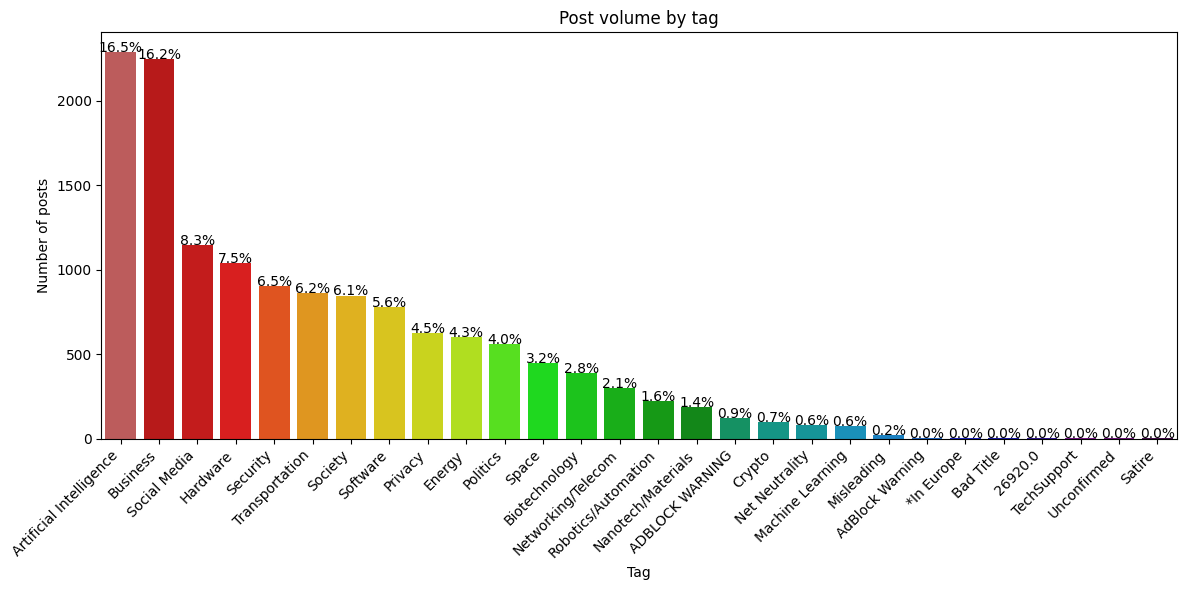

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 4.05 µs


In [43]:
# Aggregate the count of posts by tag in PySpark
tag_counts = transformed_posts_df.groupBy('tag').count().orderBy('count', ascending=False)

# Collect the aggregated data to the driver node
tag_counts_collected = tag_counts.collect()

# Extract the tags and their corresponding counts
# This will list comprehensions extract the tag names and their counts from the collected data, preparing them for visualization.
tags = [row['tag'] for row in tag_counts_collected]
counts = [row['count'] for row in tag_counts_collected]

# Now use matplotlib and seaborn to plot the counts
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=tags, y=counts, palette='nipy_spectral_r')
plt.title('Post volume by tag')
plt.xlabel('Tag')
plt.ylabel('Number of posts')
plt.xticks(rotation=45, ha='right')

# Add percentage labels on top of each bar
total = sum(counts)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.2, f'{counts[i]/total:.1%}', ha='center')

plt.tight_layout()
plt.show()
%time

/var/folders/jj/fs7p7dsj4gddnm_m6_kwhh140000gn/T/ipykernel_18125/3215411103.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=tags, y=counts, palette='nipy_spectral_r')


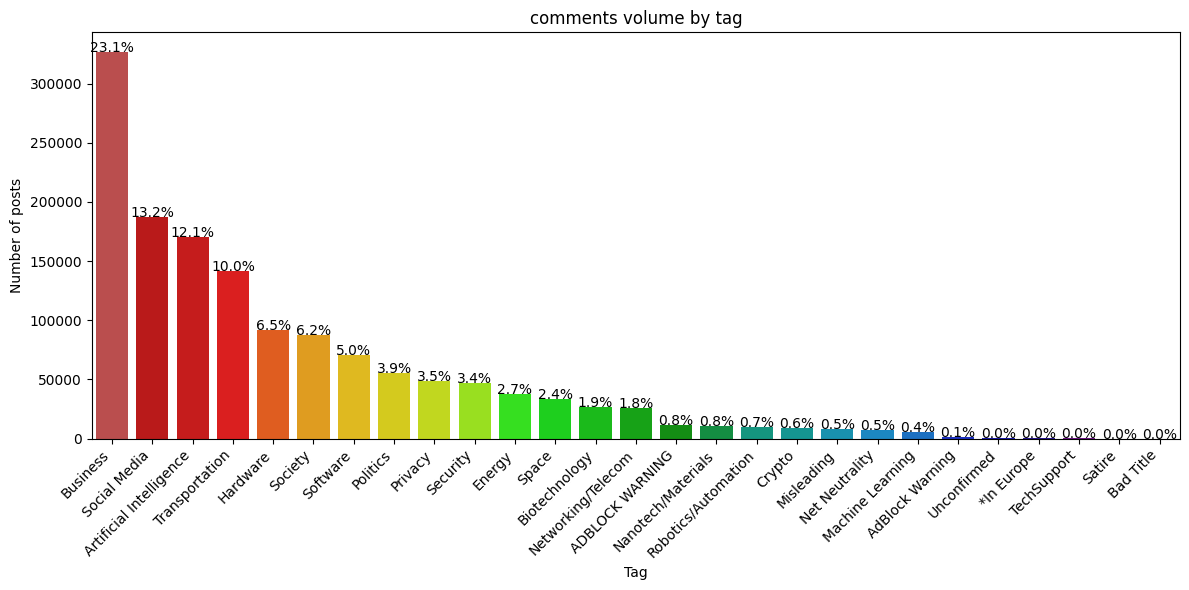

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [44]:
# Aggregate the count of comments by tag in PySpark
tag_counts = transformed_comments_df.groupBy('tag').count().orderBy('count', ascending=False)

# Collect the aggregated data to the driver node
tag_counts_collected = tag_counts.collect()

# Extract the tags and their corresponding counts
tags = [row['tag'] for row in tag_counts_collected]
counts = [row['count'] for row in tag_counts_collected]

# Now use matplotlib and seaborn to plot the counts
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=tags, y=counts, palette='nipy_spectral_r')
plt.title('comments volume by tag')
plt.xlabel('Tag')
plt.ylabel('Number of posts')
plt.xticks(rotation=45, ha='right')

# Add percentage labels on top of each bar
total = sum(counts)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.2, f'{counts[i]/total:.1%}', ha='center')

plt.tight_layout()
plt.show()
%time

### Adding 'year' and 'month' columns to the DataFrame is useful for analyses that require data aggregation or filtering by year. This enables further granularity in data analysis, allowing for monthly trends or patterns to be observed and analyzed.

In [45]:
# Add 'year' and 'month' columns to the DataFrame
transformed_posts_df = transformed_posts_df.withColumn("year", year("datetime"))

transformed_posts_df = transformed_posts_df.withColumn("month", month("datetime"))
%time

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


In [33]:
transformed_posts_df.show()
%time

+-------+----------+--------------------+-------------------+--------------------+-------+--------+--------------------+--------------------+----------+-----------------+----------------+-----------+----+-----+
|post_id|comment_id|              author|           datetime|               title|  score|comments|                text|                 tag|      date|has_comments_flag|total_word_count|text_length|year|month|
+-------+----------+--------------------+-------------------+--------------------+-------+--------+--------------------+--------------------+----------+-----------------+----------------+-----------+----+-----+
|15gznc6|      NULL|ShadowBannedAugustus|2023-08-03 09:50:40|Meta releases ope...|    4.0|     5.0|meta releases ope...|Artificial Intell...|2023-08-03|                1|               8|         51|2023|    8|
|15hfmfs|      NULL|           chrisdh79|2023-08-03 20:51:26|FCC fines robocal...| 1095.0|    28.0|fcc fines robocal...|  Networking/Telecom|2023-08-03|    

#### Below conversion is used for final data analysis steps, leveraging Pandas' for tasks like pivoting and plotting, which is less straightforward in Spark.

In [46]:
# Aggregate post volume by year, month, and tag for comments
tag_counts = transformed_posts_df.groupBy('year', 'month', 'tag').count()

# Calculate the total counts for each year and month
total_counts = tag_counts.groupBy('year', 'month').agg(F.sum('count').alias('total'))

# Join the total counts back to the tag counts
tag_with_total = tag_counts.join(total_counts, ['year', 'month'])

# Calculate the percentage for each tag
tag_with_percentage = tag_with_total.withColumn('percentage', (F.col('count') / F.col('total')) * 100)

# Now collect the data and use Pandas for the final pivot and plotting
tag_percentage_collected = tag_with_percentage.toPandas()
%time

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs


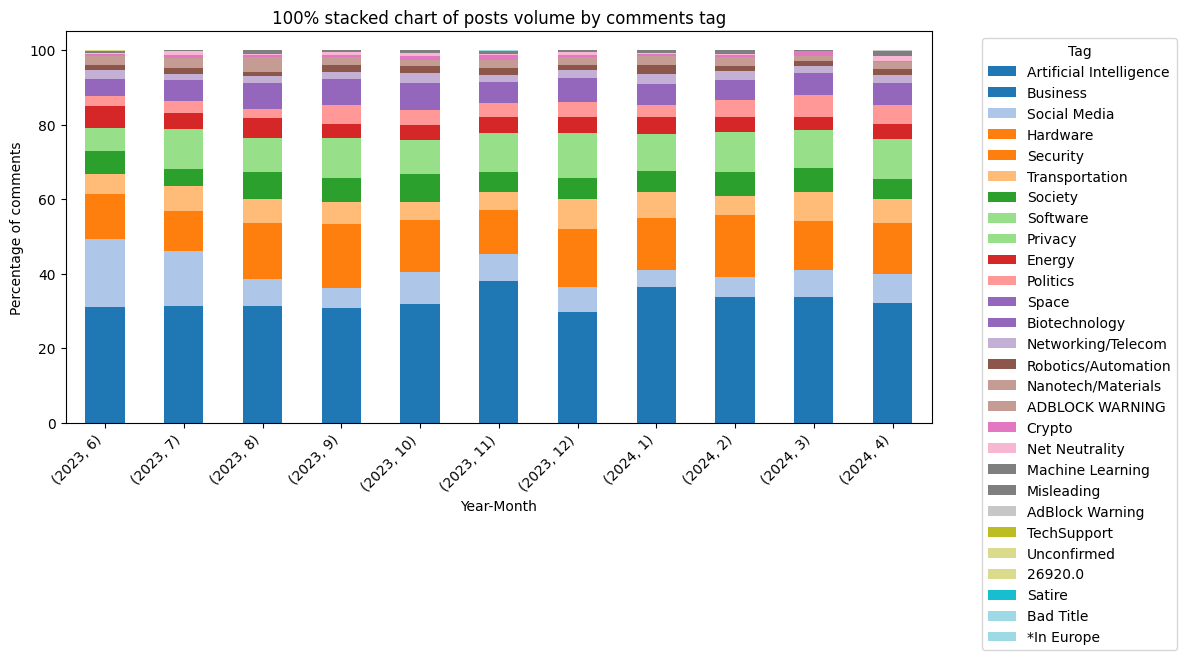

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


In [47]:
# Creating a pivot table with Pandas
pivot_table_tag_percentage = tag_percentage_collected.pivot_table(index=['year', 'month'], columns='tag', values='percentage')

# Sorting the columns based on the total percentage
pivot_table_tag_percentage_sorted = pivot_table_tag_percentage.loc[:, pivot_table_tag_percentage.sum().sort_values(ascending=False).index]

# Plotting 100% stacked bar chart with Pandas and Matplotlib
pivot_table_tag_percentage_sorted.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title('100% stacked chart of posts volume by comments tag')
plt.xlabel('Year-Month')
plt.ylabel('Percentage of comments')
plt.legend(title='Tag', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
%time

In [48]:
# Reset the index to convert the MultiIndex into columns in the Pandas DataFrame
summary_df_tag_share_post = pivot_table_tag_percentage_sorted.reset_index()

# Now, 'summary_df_tag_share_post' is a regular Pandas DataFrame with 'year' and 'month' as columns
summary_df_tag_share_post
%time

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 6.91 µs


### Adding 'year' and 'month' columns to the DataFrame is useful for analyses that require data aggregation or filtering by year. This enables further granularity in data analysis, allowing for monthly trends or patterns to be observed and analyzed.

In [49]:
# Add 'year' and 'month' columns to the comments DataFrame
transformed_comments_df = transformed_comments_df.withColumn("year", year("datetime"))
transformed_comments_df = transformed_comments_df.withColumn("month", month("datetime"))
%time

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


/Users/monicalokare/anaconda3/envs/pyspark_env/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6898: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


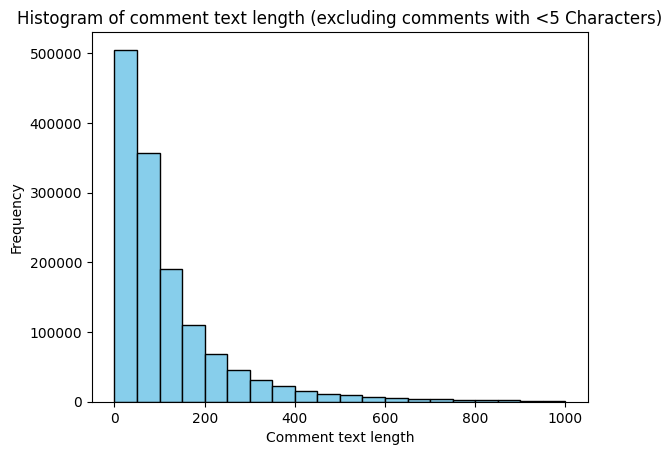

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 9.06 µs


In [59]:
# Filtering out comments with less than 5 characters
comments_with_over5charlen = transformed_comments_df.filter(length('text') >= 5)

# Getting the lengths of the filtered comments
comment_text_lengths_v2 = comments_with_over5charlen.select(length('text').alias('text_length'))

# Convert DataFrame to Pandas for plotting
comment_text_lengths_pd = comment_text_lengths_v2.toPandas()

# Defining custom bins
# Bins from 0 to 1000 with step size 50
custom_bins = np.arange(0, 1001, 50)  
# Appending infinity to include values above 1000
custom_bins = np.append(custom_bins, np.inf)  

# Plotting the histogram with custom bins
plt.hist(comment_text_lengths_pd['text_length'], bins=custom_bins, color='skyblue', edgecolor='black')
plt.title('Histogram of comment text length (excluding comments with <5 Characters)')
plt.xlabel('Comment text length')
plt.ylabel('Frequency')
plt.show()
%time

In [60]:
# Get the number of rows in the raw comments data
raw_comments_count = working_df_dedup_comment.count()
print("Raw comments data count:")
print(raw_comments_count)

# Get the number of rows after excluding comments with less than 5 characters
comments_over_5_char_count = comments_with_over5charlen.count()
print("\nComments dataset count after excluding comments with <5 characters:")
print(comments_over_5_char_count)

# Calculate the percentage difference
percentage_change = ((raw_comments_count - comments_over_5_char_count) / raw_comments_count) * 100

print(f"\nPercentage difference: {percentage_change:.2f}%")
%time

Raw comments data count:
1414204



Comments dataset count after excluding comments with <5 characters:
1404703

Percentage difference: 0.67%
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 37.9 µs


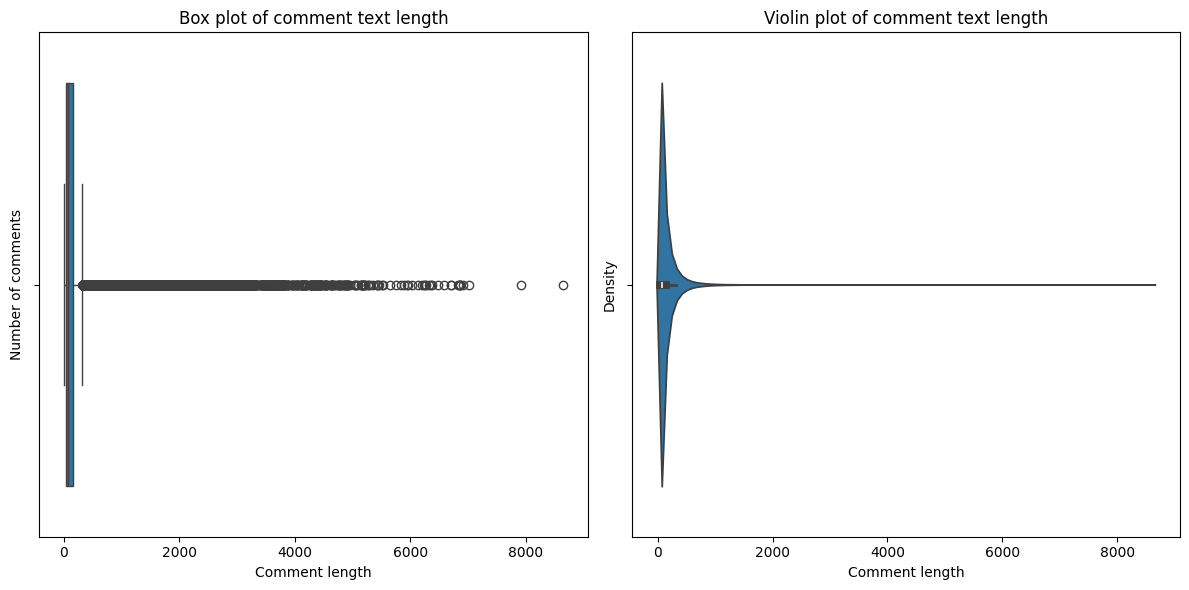

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 12.2 µs


In [61]:
# Convert the PySpark DataFrame to Pandas DataFrame
comments_pd = comments_with_over5charlen.toPandas()

# Calculate the length of each comment text
comments_pd['comment_length'] = comments_pd['text'].apply(len)

# Setting up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plotting box plot of comment length
sns.boxplot(x='comment_length', data=comments_pd, ax=axes[0])
axes[0].set_title('Box plot of comment text length')
axes[0].set_xlabel('Comment length')
axes[0].set_ylabel('Number of comments')

# Plotting violin plot of comment length
sns.violinplot(x='comment_length', data=comments_pd, ax=axes[1])
axes[1].set_title('Violin plot of comment text length')
axes[1].set_xlabel('Comment length')
axes[1].set_ylabel('Density')

# Show the plots
plt.tight_layout()
plt.show()
%time

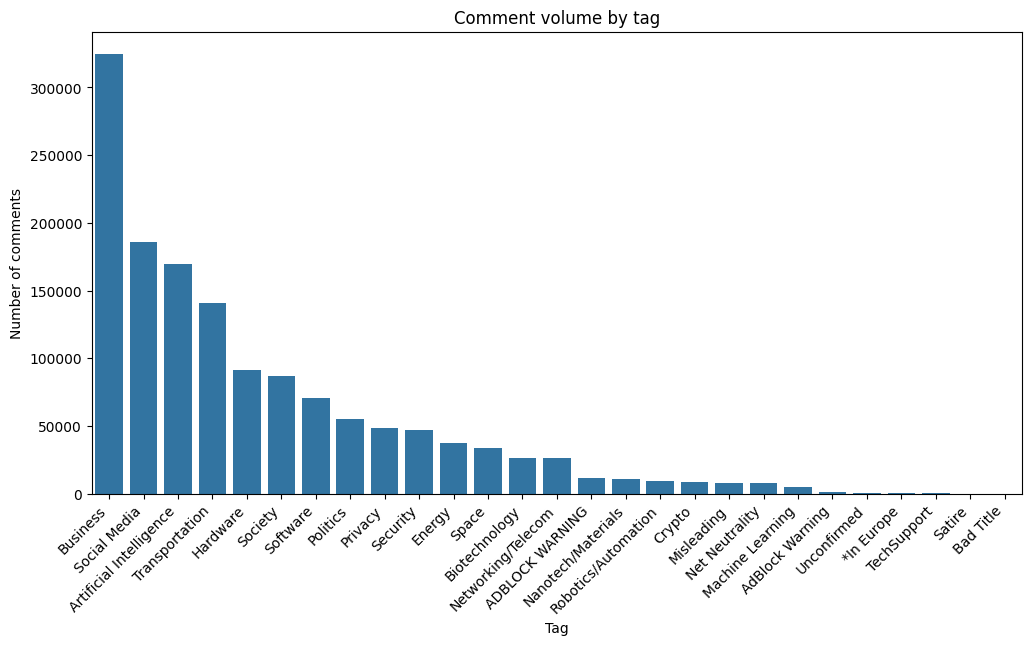

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 11 µs


In [62]:
# Fill missing values in the 'tag' column with 'No tag'
comments_with_over5charlen_filled = comments_with_over5charlen.fillna({'tag': 'No tag'})

# Convert the PySpark DataFrame to Pandas DataFrame
comments_filled_pd = comments_with_over5charlen_filled.toPandas()

# Visualize the count of comments by tag
plt.figure(figsize=(12, 6))
sns.countplot(data=comments_filled_pd, x='tag', order=comments_filled_pd['tag'].value_counts().index)
plt.title('Comment volume by tag')
plt.xlabel('Tag')
plt.ylabel('Number of comments')
plt.xticks(rotation=45, ha='right')
plt.show()
%time

In [64]:
# Define your cleaning function
def clean_text_function_reddit(text):
    # Implement your cleaning logic here
    # For example:
    cleaned_text = text.lower().strip()  # Convert to lowercase and remove leading/trailing whitespaces
    return cleaned_text

# Register the cleaning function as a UDF
clean_text_udf = udf(clean_text_function_reddit, StringType())

# Apply the UDF to the text column and create a new column with the cleaned text
comments_with_over5charlen = comments_with_over5charlen.withColumn('comment_clean', clean_text_udf('text'))
%time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [66]:
# Filter out comments with less than 5 characters
comments_with_over5charlen_clean = comments_with_over5charlen.filter(length('comment_clean') >= 5)
%time

CPU times: user 6 µs, sys: 3 µs, total: 9 µs
Wall time: 16.9 µs


In [67]:
# Get the number of rows in the intermediate comments data
intermediate_comments_count = comments_with_over5charlen.count()
print("Intermediate comments data count:")
print(intermediate_comments_count)

# Get the number of rows in the cleaned comments dataset after excluding comments with less than 5 characters
cleaned_comments_count = comments_with_over5charlen_clean.count()
print("\nCleaned comments dataset count after excluding cleaned comments with <5 characters:")
print(cleaned_comments_count)

# Calculate the percentage difference
percentage_change_clean = ((intermediate_comments_count - cleaned_comments_count) / intermediate_comments_count) * 100

print(f"\nPercentage difference: {percentage_change_clean:.2f}%")
%time

Intermediate comments data count:
1404703



Cleaned comments dataset count after excluding cleaned comments with <5 characters:
1404533

Percentage difference: 0.01%
CPU times: user 12 µs, sys: 6 µs, total: 18 µs
Wall time: 839 µs


In [68]:
newtransformed_comments_df=transformed_comments_df
# Defining the columns to be dropped (comment related and raw text columns)
posts_columns_to_drop = ["comment_id", "title", "url", "text", "title_text_similarity"]

# Dropping the defined columns
posts_with_comments_final = newtransformed_comments_df.drop(*posts_columns_to_drop)


In [8]:
# Convert PySpark DataFrame to Pandas DataFrame
comments_final_pd = comments_with_over5charlen_clean.toPandas()

# Defining the columns to be dropped (post related and raw text columns)
comments_columns_to_drop = ["title", "url", "text", "comments"]

# Dropping the defined columns
comments_final_pd.drop(columns=comments_columns_to_drop, inplace=True)

#### Below conversion is used for final data analysis steps, leveraging Pandas' for tasks like pivoting and plotting, which is less straightforward in Spark.

In [50]:
transformed_comments_df.show()
%time

+-------+----------+--------------------+-------------------+-----+-----+--------+--------------------+-----------------+--------------------+----------+----------------+-----------+----+-----+
|post_id|comment_id|              author|           datetime|title|score|comments|                text|author_post_karma|                 tag|      date|total_word_count|text_length|year|month|
+-------+----------+--------------------+-------------------+-----+-----+--------+--------------------+-----------------+--------------------+----------+----------------+-----------+----+-----+
|149lbxl|   jo6l187|              TUGrad|2023-06-15 02:51:20| NULL| 23.0|    NULL|wasn musk one mai...|         143615.0|            Business|2023-06-15|               9|         54|2023|    6|
|14g6hin|   jp5xf1l|            hawklost|2023-06-23 00:41:22| NULL|  5.0|    NULL|give perfect exam...|          30316.0|            Business|2023-06-23|              69|        507|2023|    6|
|1582bdt|   jt957kb|       Vag

In [51]:
# Aggregate comments volume by year, month, and tag for comments
tag_counts = transformed_comments_df.groupBy('year', 'month', 'tag').count()

# Calculate the total counts for each year and month
total_counts = tag_counts.groupBy('year', 'month').agg(F.sum('count').alias('total'))

# Join the total counts back to the tag counts
tag_with_total = tag_counts.join(total_counts, ['year', 'month'])

# Calculate the percentage for each tag
tag_with_percentage = tag_with_total.withColumn('percentage', (F.col('count') / F.col('total')) * 100)

# Now collect the data and use Pandas for the final pivot and plotting
tag_percentage_collected = tag_with_percentage.toPandas()
%time

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


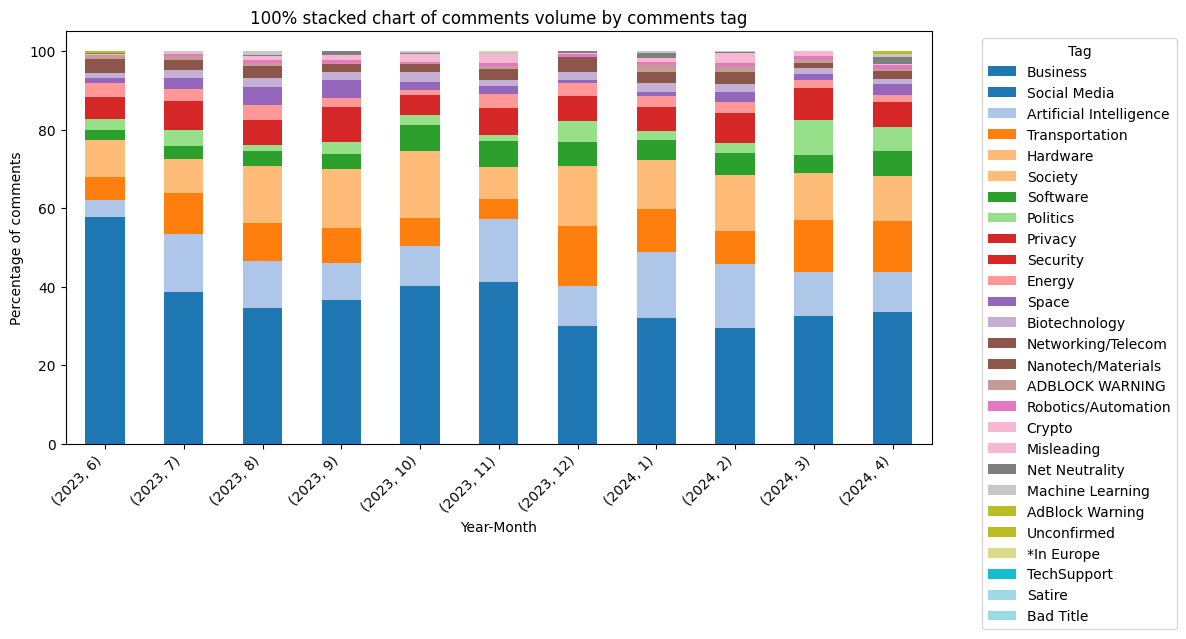

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs


In [52]:
# Creating a pivot table with Pandas
pivot_table_tag_percentage = tag_percentage_collected.pivot_table(index=['year', 'month'], columns='tag', values='percentage')

# Sorting the columns based on the total percentage
pivot_table_tag_percentage_sorted = pivot_table_tag_percentage.loc[:, pivot_table_tag_percentage.sum().sort_values(ascending=False).index]

# Plotting 100% stacked bar chart with Pandas and Matplotlib
pivot_table_tag_percentage_sorted.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title('100% stacked chart of comments volume by comments tag')
plt.xlabel('Year-Month')
plt.ylabel('Percentage of comments')
plt.legend(title='Tag', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
%time

In [53]:
# Reset the index to convert the MultiIndex into columns in the Pandas DataFrame
summary_df_tag_share_comment = pivot_table_tag_percentage_sorted.reset_index()

# Now, 'summary_df_tag_share_comment' is a regular Pandas DataFrame with 'year' and 'month' as columns
summary_df_tag_share_comment
%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


In [54]:
transformed_posts_df.show()
%time

+-------+----------+--------------------+-------------------+--------------------+-------+--------+--------------------+-----------------+--------------------+----------+-----------------+----------------+-----------+----+-----+
|post_id|comment_id|              author|           datetime|               title|  score|comments|                text|author_post_karma|                 tag|      date|has_comments_flag|total_word_count|text_length|year|month|
+-------+----------+--------------------+-------------------+--------------------+-------+--------+--------------------+-----------------+--------------------+----------+-----------------+----------------+-----------+----+-----+
|141fc0m|      NULL|       Stiven_Crysis|2023-06-05 13:54:38|With PowerVia, In...|   14.0|     1.0|powervia intel ac...|           1357.0|            Hardware|2023-06-05|                1|               5|         47|2023|    6|
|15gznc6|      NULL|ShadowBannedAugustus|2023-08-03 09:50:40|Meta releases ope...|  

In [43]:
#Verify the columns and it's datatypes
transformed_posts_df.dtypes

[('post_id', 'string'),
 ('comment_id', 'string'),
 ('author', 'string'),
 ('datetime', 'timestamp'),
 ('title', 'string'),
 ('score', 'string'),
 ('comments', 'string'),
 ('text', 'string'),
 ('tag', 'string'),
 ('date', 'string'),
 ('has_comments_flag', 'int'),
 ('total_word_count', 'int'),
 ('text_length', 'int'),
 ('year', 'int'),
 ('month', 'int')]

###  PySpark does not have a native stemmer or lemmatizer in MLlib. Therefore, we need to perform stemming or lemmatization, using a user-defined function (UDF) and then apply it to the DataFrame. Alternatively, we  consider using the Natural Language Toolkit (nltk) within a single machine context.

#### The variable 'Stemm_lemm_post_df' is intended to be used for stemming and lemmatizing the posts, and other NLP preprocessing tasks.

In [44]:
# Assign the transformed DataFrame to a new variable for further processing
Stemm_lemm_post_df = transformed_posts_df

In [45]:
Stemm_lemm_post_df.show()

+-------+----------+--------------------+-------------------+--------------------+-------+--------+--------------------+--------------------+----------+-----------------+----------------+-----------+----+-----+
|post_id|comment_id|              author|           datetime|               title|  score|comments|                text|                 tag|      date|has_comments_flag|total_word_count|text_length|year|month|
+-------+----------+--------------------+-------------------+--------------------+-------+--------+--------------------+--------------------+----------+-----------------+----------------+-----------+----+-----+
|15gznc6|      NULL|ShadowBannedAugustus|2023-08-03 09:50:40|Meta releases ope...|    4.0|     5.0|meta releases ope...|Artificial Intell...|2023-08-03|                1|               8|         51|2023|    8|
|15hfmfs|      NULL|           chrisdh79|2023-08-03 20:51:26|FCC fines robocal...| 1095.0|    28.0|fcc fines robocal...|  Networking/Telecom|2023-08-03|    

## A. Stemming and Lemmatization on dataframe for posts
#### The Porter Stemmer is a widely used algorithm for stemming English words to their root forms.


In [47]:
# Initialize the Porter Stemmer
stemmer = PorterStemmer()

# Define the function for stemming
def stem_text(text):
    # Tokenize the text into words
    words = nltk.word_tokenize(text)
  
    # Stem each word in the tokenized text
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # Join the stemmed words back into a string
    return ' '.join(stemmed_words)
    
# Register the UDF
stem_text_udf = udf(stem_text, StringType())

# Apply the UDF to the 'text' column of your DataFrame. Effectively storing the stemmed text alongside the original data.
Stemm_lemm_post_df = Stemm_lemm_post_df.withColumn("text_cleaned_stemmed", stem_text_udf(col("text")))

# Show some of the stemmed texts
Stemm_lemm_post_df.select("text_cleaned_stemmed").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------+
|text_cleaned_stemmed                                                                                                                       |
+-------------------------------------------------------------------------------------------------------------------------------------------+
|meta releas open sourc ai audio tool audiocraft                                                                                            |
|fcc fine robocal record 300m block billion scam call                                                                                       |
|uk owner smart home devic ask swath person data                                                                                            |
|gener ai exist transform                                                                                                                   |
|eu fr

### Lemmatization for posts dataframe. WordNetLemmatizer is used for lemmatizing words, i.e., reducing them to their base or root form.

Generating top 1-grams


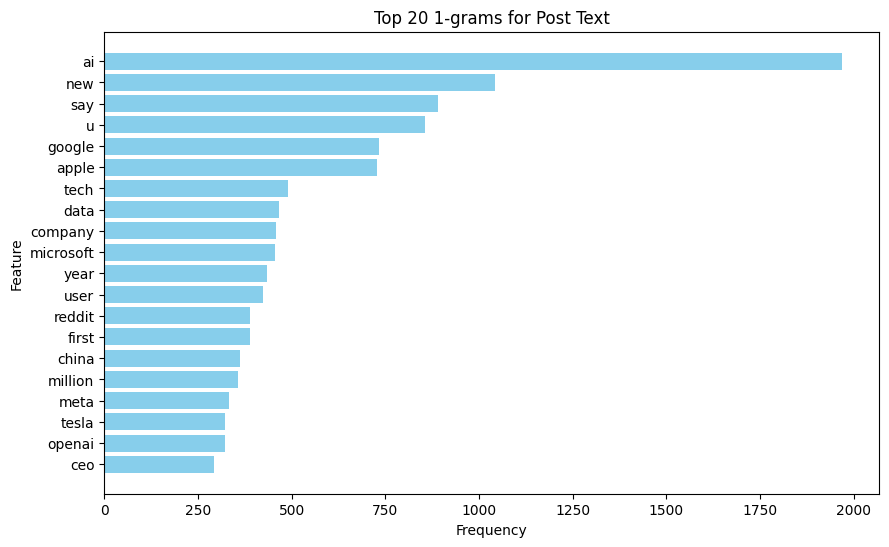

Generating top 2-grams


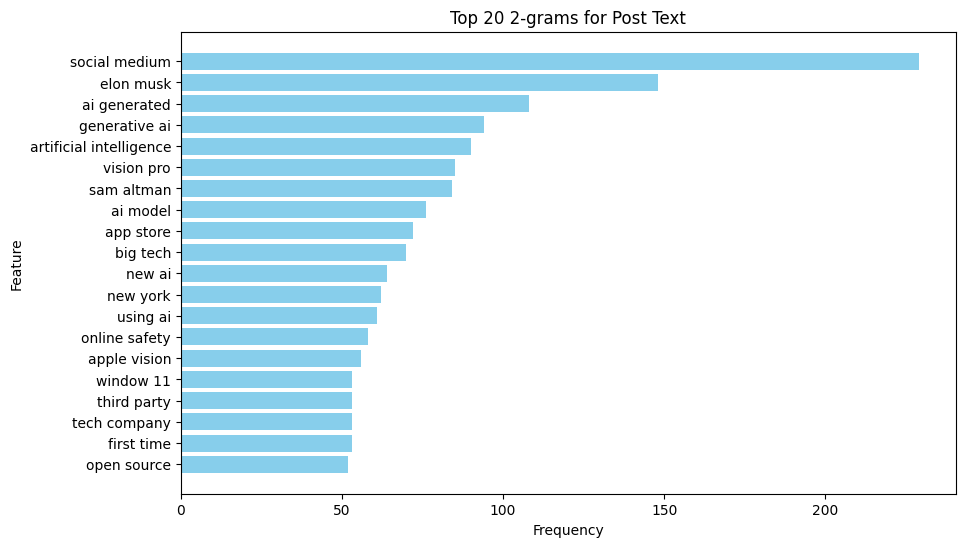

Generating top 3-grams


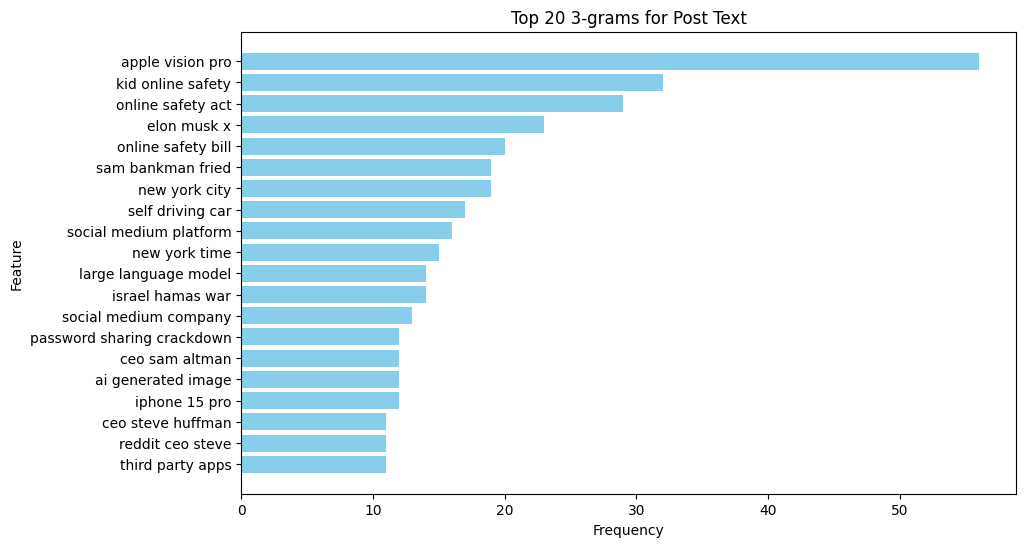

In [49]:
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the UDF to perform lemmatization on a single text
@udf(StringType())
def lemmatize_text(text):
    words = word_tokenize(text)  # Tokenizes the input text into individual words.
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]  # Applies lemmatization to each word.
    return ' '.join(lemmatized_words)  # Joins the lemmatized words back into a single string.

# Applying the lemmatization UDF to a DataFrame column
Stemm_lemm_post_df = Stemm_lemm_post_df.withColumn("text_lemmatized", lemmatize_text(col("text")))
# Adds a new column 'text_lemmatized' to the DataFrame by applying the 'lemmatize_text' UDF.

In [ ]:
# Define a function to generate n-grams and return the top N features
def generate_ngrams(df, n, N=20):
    # Setup for generating n-grams within a DataFrame.
    tokenizer = Tokenizer(inputCol="text_lemmatized", outputCol="tokens")  # Tokenizes the lemmatized text.
    ngram = NGram(n=n, inputCol="tokens", outputCol="ngrams")  # Creates n-grams from the tokenized text.

    # Build a pipeline with tokenizer and n-gram stages
    pipeline = Pipeline(stages=[tokenizer, ngram])  # Configures a pipeline with the defined stages.

    # Fit and apply the pipeline
    model = pipeline.fit(df)  # Fits the pipeline to the DataFrame.
    df = model.transform(df)  # Transforms the DataFrame using the pipeline.

    # Expand and count n-grams
    df = df.withColumn('ngram', explode(col('ngrams')))  # Creates a new row for each n-gram.
    ngram_counts = df.groupBy('ngram').count()  # Counts occurrences of each n-gram.

    # Retrieve the top N n-grams
    top_ngrams = ngram_counts.orderBy('count', ascending=False).limit(N)  # Orders n-grams by count and limits to top N.
    return top_ngrams

In [84]:
# Plotting function for visualization
def plot_top_features(feature_names, feature_counts, title):
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, feature_counts, color='skyblue')  # Creates a horizontal bar plot.
    plt.xlabel('Frequency')  # Label for the x-axis.
    plt.ylabel('Feature')  # Label for the y-axis.
    plt.title(title)  # Plot title.
    plt.gca().invert_yaxis()  # Inverts the y-axis to display the highest values at the top.
    plt.show()  # Displays the plot.

# Usage for unigrams, bigrams, and trigrams
for n in [1, 2, 3]:
    print(f"Generating top {n}-grams")
    top_ngrams_df = generate_ngrams(Stemm_lemm_post_df, n)  # Calls the function to generate top n-grams.
    top_ngrams_collected = top_ngrams_df.collect()  # Collects the results to the driver.
    feature_names, feature_counts = zip(*[(row['ngram'], row['count']) for row in top_ngrams_collected])
    plot_top_features(feature_names, feature_counts, title=f'Top 20 {n}-grams for Post Text')  # Calls the plotting function.

In [51]:
Stemm_lemm_post_df.dtypes

[('post_id', 'string'),
 ('comment_id', 'string'),
 ('author', 'string'),
 ('datetime', 'timestamp'),
 ('title', 'string'),
 ('score', 'string'),
 ('comments', 'string'),
 ('text', 'string'),
 ('tag', 'string'),
 ('date', 'string'),
 ('has_comments_flag', 'int'),
 ('total_word_count', 'int'),
 ('text_length', 'int'),
 ('year', 'int'),
 ('month', 'int'),
 ('text_cleaned_stemmed', 'string'),
 ('text_lemmatized', 'string')]

### Sentiment Analysis for posts dataframe. 
### VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.
### The UDF 'get_sentiment' is applied to each 'text_lemmatized' entry, storing results in a new 'sentiment_result' column as structured data.


In [54]:
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define the schema for the UDF return type
schema = StructType([
    StructField("compound", DoubleType(), False),
    StructField("sentiment", StringType(), False)
])
# Define a UDF to get the sentiment score and classification
@udf(schema)
def get_sentiment(text):
    if text:
        sentiment_score = sia.polarity_scores(text)  # Compute sentiment scores using VADER
        # Determine the sentiment category based on the compound score
        sentiment = 'positive' if sentiment_score['compound'] >= 0.05 else 'negative' if sentiment_score['compound'] <= -0.05 else 'neutral'
        return (sentiment_score['compound'], sentiment)
    else:
        return (0.0, 'neutral')  # Handle possible null values by returning neutral sentiment

# Apply the UDF to the 'text_lemmatized' column to create new columns for sentiment
Stemm_lemm_post_df = Stemm_lemm_post_df.withColumn("sentiment_result", get_sentiment(col("text_lemmatized")))
# The UDF 'get_sentiment' is applied to each 'text_lemmatized' entry, storing results in a new 'sentiment_result' column as structured data.

# Extract the compound score and sentiment into separate columns
Stemm_lemm_post_df = Stemm_lemm_post_df.withColumn("sentiment_score", col("sentiment_result").compound)
Stemm_lemm_post_df = Stemm_lemm_post_df.withColumn("sentiment", col("sentiment_result").sentiment)

# The intermediate 'sentiment_result' column is dropped to clean up the DataFrame.
Stemm_lemm_post_df = Stemm_lemm_post_df.drop("sentiment_result")

# Show some results to verify
Stemm_lemm_post_df.select("text_lemmatized", "sentiment_score", "sentiment").show(truncate=False)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sumeetkulkarni/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


+--------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+---------+
|text_lemmatized                                                                                                                                               |sentiment_score|sentiment|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+---------+
|meta release open source ai audio tool audiocraft                                                                                                             |0.0            |neutral  |
|fcc fine robocaller record 300m blocking billion scam call                                                                                                    |-0.6705        |negative |
|uk owner smart home device asked swathe personal data           

### Concatenates date columns, aggregates data by sentiment over time, and then visualize post data using a stacked bar chart

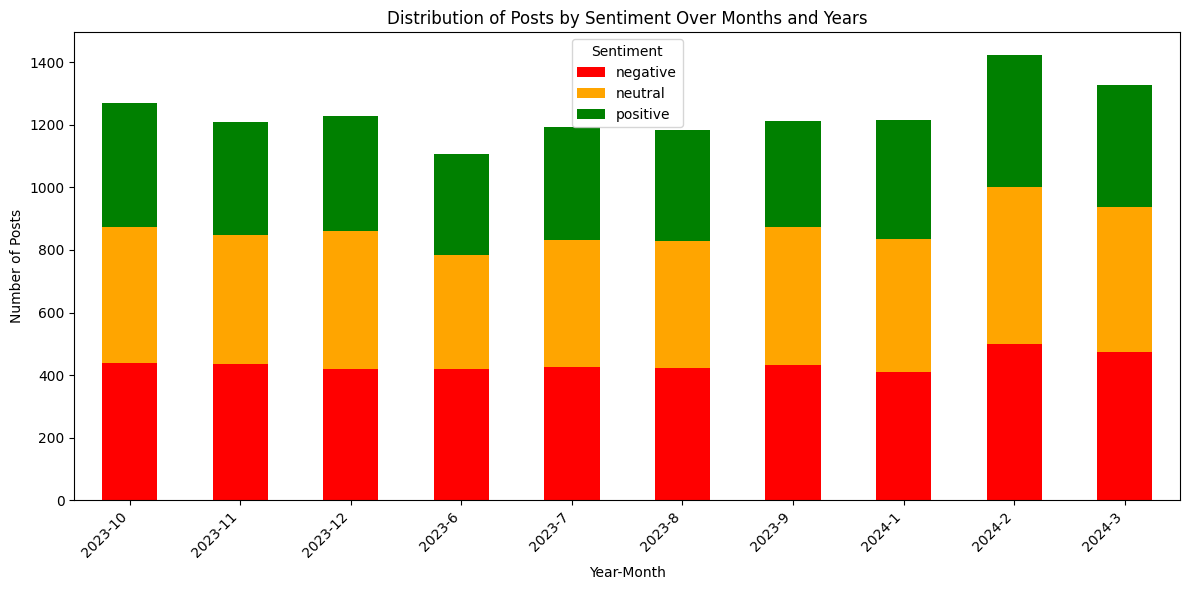

In [55]:
# Concatenate year and month into a new column for easier grouping
Stemm_lemm_post_df = Stemm_lemm_post_df.withColumn("year_month", concat_ws("-", col("year"), col("month")))

# Group by 'year_month' and 'sentiment', and count the number of posts
sentiment_counts = Stemm_lemm_post_df.groupBy("year_month", "sentiment").count()

# Convert the DataFrame to Pandas for plotting
sentiment_counts_pandas = sentiment_counts.toPandas()

# Pivot the data for plotting
sentiment_pivot = sentiment_counts_pandas.pivot(index='year_month', columns='sentiment', values='count')
sentiment_pivot = sentiment_pivot.fillna(0)  # Fill NA values with 0

# Define custom colors for each sentiment
senti_colors = {'positive': 'green', 'negative': 'red', 'neutral': 'orange'}

# Plotting stacked bar chart with custom colors
ax = sentiment_pivot.plot(kind='bar', stacked=True, figsize=(12, 6), color=[senti_colors.get(x, '#333333') for x in sentiment_pivot.columns])
plt.title('Distribution of Posts by Sentiment Over Months and Years')
plt.xlabel('Year-Month')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Sentiment', labels=sentiment_pivot.columns)
plt.tight_layout()
plt.show()


### Get the count of sentiments(positive, negative and neutral) for each month and year

In [56]:
# Group by 'year', 'month', and 'sentiment' and count rows
# Pivot to transform sentiments into separate columns with counts
post_volume_over_time_sentiment = Stemm_lemm_post_df.groupBy("year", "month")\
    .pivot("sentiment")\
    .count()

# Fill null values with zero after pivoting
post_volume_over_time_sentiment = post_volume_over_time_sentiment.na.fill(0)

# Displaying the DataFrame in a tabular format
print("Tabular summary of post volume by sentiment over time:\n")
post_volume_over_time_sentiment.show(truncate=False)


Tabular summary of post volume by sentiment over time:



+----+-----+--------+-------+--------+
|year|month|negative|neutral|positive|
+----+-----+--------+-------+--------+
|2023|8    |422     |408    |353     |
|2023|9    |433     |441    |338     |
|2024|3    |475     |464    |389     |
|2023|7    |426     |406    |360     |
|2023|6    |419     |364    |324     |
|2024|2    |499     |501    |425     |
|2023|11   |434     |414    |360     |
|2024|1    |409     |427    |381     |
|2023|10   |439     |434    |398     |
|2023|12   |418     |443    |369     |
+----+-----+--------+-------+--------+



### Pie chart to understand the distribution

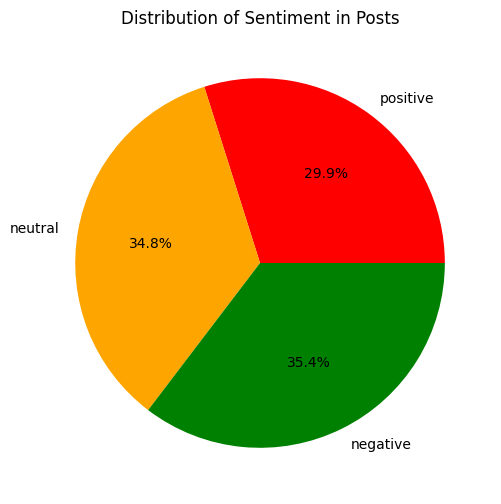

In [58]:
# Aggregate the count of each sentiment
sentiment_counts_df = Stemm_lemm_post_df.groupBy("sentiment").count()

# Collect the data to the driver as a Pandas DataFrame
sentiment_counts_pandas = sentiment_counts_df.toPandas().set_index("sentiment")

# Defining custom colors for each sentiment, ensuring order by matching the index
senti_colors = ['red', 'orange', 'green']  # Order needs to match with the sentiment_counts_pandas index if specific
senti_labels = sentiment_counts_pandas.index  # This will fetch labels in the order they are stored

plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts_pandas['count'], labels=senti_labels, autopct='%1.1f%%', colors=senti_colors)
plt.title('Distribution of Sentiment in Posts')
plt.show()


## B. Stemming and Lemmatization on comments dataframe

In [67]:
# Assign the transformed comments DataFrame to a new variable for further processing
Stemm_lemm_comments_df = transformed_comments_df 

In [68]:
Stemm_lemm_comments_df.dtypes

[('post_id', 'string'),
 ('comment_id', 'string'),
 ('author', 'string'),
 ('datetime', 'timestamp'),
 ('title', 'string'),
 ('score', 'string'),
 ('comments', 'string'),
 ('text', 'string'),
 ('tag', 'string'),
 ('date', 'string'),
 ('total_word_count', 'int'),
 ('text_length', 'int'),
 ('year', 'int'),
 ('month', 'int')]

In [69]:
Stemm_lemm_comments_df.show()

+-------+----------+-------------------+-------------------+-----+-----+--------+--------------------+--------------------+----------+----------------+-----------+----+-----+
|post_id|comment_id|             author|           datetime|title|score|comments|                text|                 tag|      date|total_word_count|text_length|year|month|
+-------+----------+-------------------+-------------------+-----+-----+--------+--------------------+--------------------+----------+----------------+-----------+----+-----+
|140jyie|   jmwngqk|             pwalkz|2023-06-04 20:42:10| NULL|  3.0|    NULL|end humanity litt...|Artificial Intell...|2023-06-04|               7|         45|2023|    6|
|14987y2|   jo6nc2y|  Forward-Documents|2023-06-15 03:12:50| NULL| -1.0|    NULL|normal amount fin...|        Social Media|2023-06-15|               7|         49|2023|    6|
|14bpd1f|   joh0gkp|         hackergame|2023-06-17 14:13:49| NULL|  1.0|    NULL|use hollywood de ...|      Transportation|20

In [70]:
# Initialize the Porter Stemmer
stemmer = PorterStemmer()

# Define the function for stemming
def stem_text(text):
    # Tokenize the text into words
    words = nltk.word_tokenize(text)
    # Stem each word in the tokenized text
    stemmed_words = [stemmer.stem(word) for word in words]
    # Join the stemmed words back into a string
    return ' '.join(stemmed_words)

# Register the UDF
stem_text_udf = udf(stem_text, StringType())

# Apply the UDF to the 'text' column of your DataFrame
Stemm_lemm_comments_df = Stemm_lemm_comments_df.withColumn("text_cleaned_stemmed", stem_text_udf(col("text")))

# Show some of the stemmed texts
Stemm_lemm_comments_df.select("text_cleaned_stemmed").show(truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_cleaned_stemmed                                                                                                                                                                                                                                                                                               |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|end human littl much mayb end capit                                  

In [71]:
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the UDF to perform lemmatization on a single text
@udf(StringType())
def lemmatize_text(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Applying the lemmatization UDF to a DataFrame column
Stemm_lemm_comments_df = Stemm_lemm_comments_df.withColumn("text_lemmatized", lemmatize_text(col("text")))

In [73]:
# Define a function to generate n-grams and return the top N features
def generate_ngrams(df, n, N=20):
    # Tokenize the text
    tokenizer = Tokenizer(inputCol="text_lemmatized", outputCol="tokens")
    
    # Create n-grams
    ngram = NGram(n=n, inputCol="tokens", outputCol="ngrams")

    # Build a pipeline with tokenizer and n-gram stages
    pipeline = Pipeline(stages=[tokenizer, ngram])

    # Fit the pipeline to the data
    model = pipeline.fit(df)

    # Transform the data using the fitted pipeline
    df = model.transform(df)

    # Explode the n-grams into a new row for each n-gram
    df = df.withColumn('ngram', explode(col('ngrams')))

    # Group by the n-gram column and count occurrences
    ngram_counts = df.groupBy('ngram').count()

    # Order by the count and take the top N features
    top_ngrams = ngram_counts.orderBy('count', ascending=False).limit(N)

    return top_ngrams


Generating top 1-grams from comments


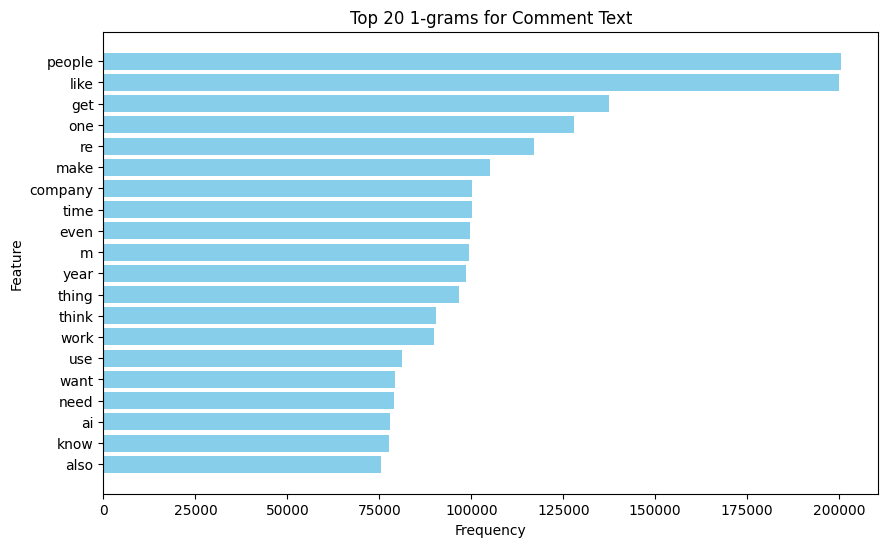

Generating top 2-grams from comments


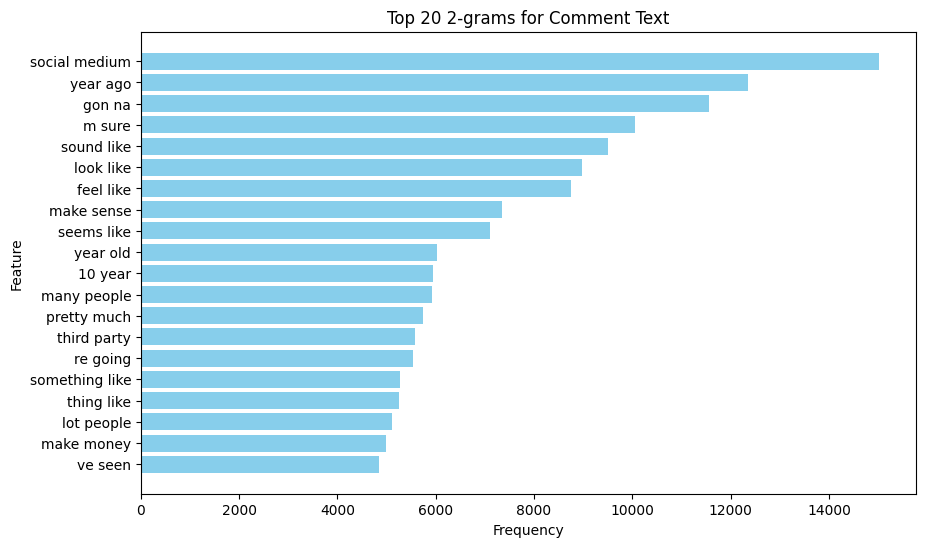

Generating top 3-grams from comments


24/04/28 01:58:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/04/28 01:58:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/04/28 01:58:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/04/28 01:58:47 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/04/28 01:58:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/04/28 01:58:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/04/28 01:58:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/04/28 01:58:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/04/28 01:58:49 WARN RowBasedKeyValueBatch: Calling spill() on

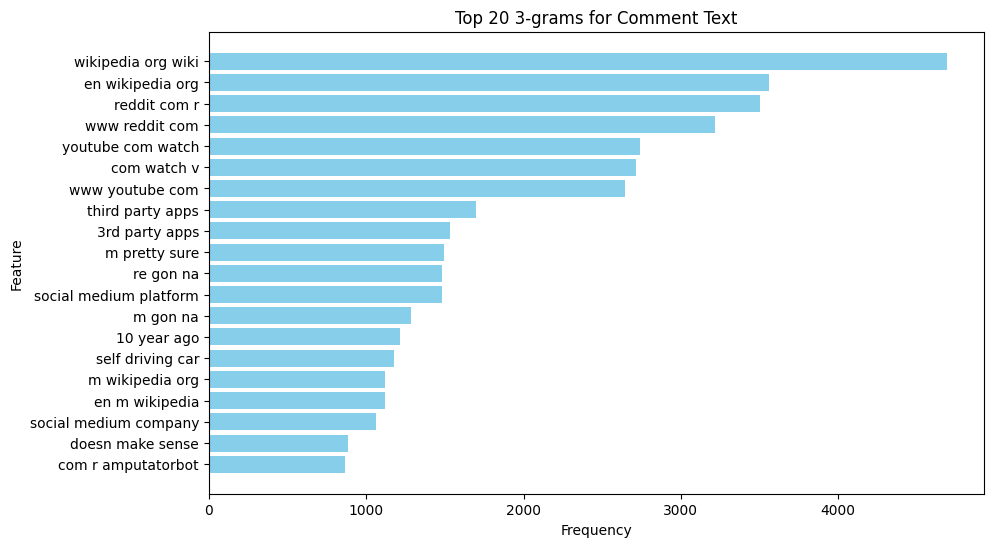

In [75]:
# Plotting function
def plot_top_features(feature_names, feature_counts, title):
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, feature_counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Feature')
    plt.title(title)
    plt.gca().invert_yaxis()  # Show in descending order
    plt.show()

# Usage for unigrams, bigrams, and trigrams on comments DataFrame
for n in [1, 2, 3]:
    print(f"Generating top {n}-grams from comments")
    top_ngrams_df = generate_ngrams(Stemm_lemm_comments_df, n)  # Changed DataFrame reference
    top_ngrams_collected = top_ngrams_df.collect()
    feature_names, feature_counts = zip(*[(row['ngram'], row['count']) for row in top_ngrams_collected])
    plot_top_features(feature_names, feature_counts, title=f'Top 20 {n}-grams for Comments Text')  # Changed title for clarity


In [76]:
Stemm_lemm_comments_df.dtypes

[('post_id', 'string'),
 ('comment_id', 'string'),
 ('author', 'string'),
 ('datetime', 'timestamp'),
 ('title', 'string'),
 ('score', 'string'),
 ('comments', 'string'),
 ('text', 'string'),
 ('tag', 'string'),
 ('date', 'string'),
 ('total_word_count', 'int'),
 ('text_length', 'int'),
 ('year', 'int'),
 ('month', 'int'),
 ('text_cleaned_stemmed', 'string'),
 ('text_lemmatized', 'string')]

In [78]:
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define the schema for the UDF return type
schema = StructType([
    StructField("compound", DoubleType(), False),
    StructField("sentiment", StringType(), False)
])

# Define a UDF to get the sentiment score and classification
@udf(schema)
def get_sentiment(text):
    if text:
        sentiment_score = sia.polarity_scores(text)
        sentiment = 'positive' if sentiment_score['compound'] >= 0.05 else 'negative' if sentiment_score['compound'] <= -0.05 else 'neutral'
        return (sentiment_score['compound'], sentiment)
    else:
        return (0.0, 'neutral')  # Handle possible null values

# Assuming 'reddit_post_cleaned' is already loaded and has a 'text_lemmatized' column
# Apply the UDF to the 'text_lemmatized' column to create new columns for sentiment
Stemm_lemm_comments_df = Stemm_lemm_comments_df.withColumn("sentiment_result", get_sentiment(col("text_lemmatized")))

# Extract the compound score and sentiment into separate columns
Stemm_lemm_comments_df = Stemm_lemm_comments_df.withColumn("sentiment_score", col("sentiment_result").compound)
Stemm_lemm_comments_df = Stemm_lemm_comments_df.withColumn("sentiment", col("sentiment_result").sentiment)

# Drop the struct column if no longer needed
Stemm_lemm_comments_df = Stemm_lemm_comments_df.drop("sentiment_result")

# Show some results to verify
Stemm_lemm_comments_df.select("text_lemmatized", "sentiment_score", "sentiment").show(truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+---------+
|text_lemmatized                                                                                                                                                                                                                                                                                                                                        |sentiment_score|sentiment|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

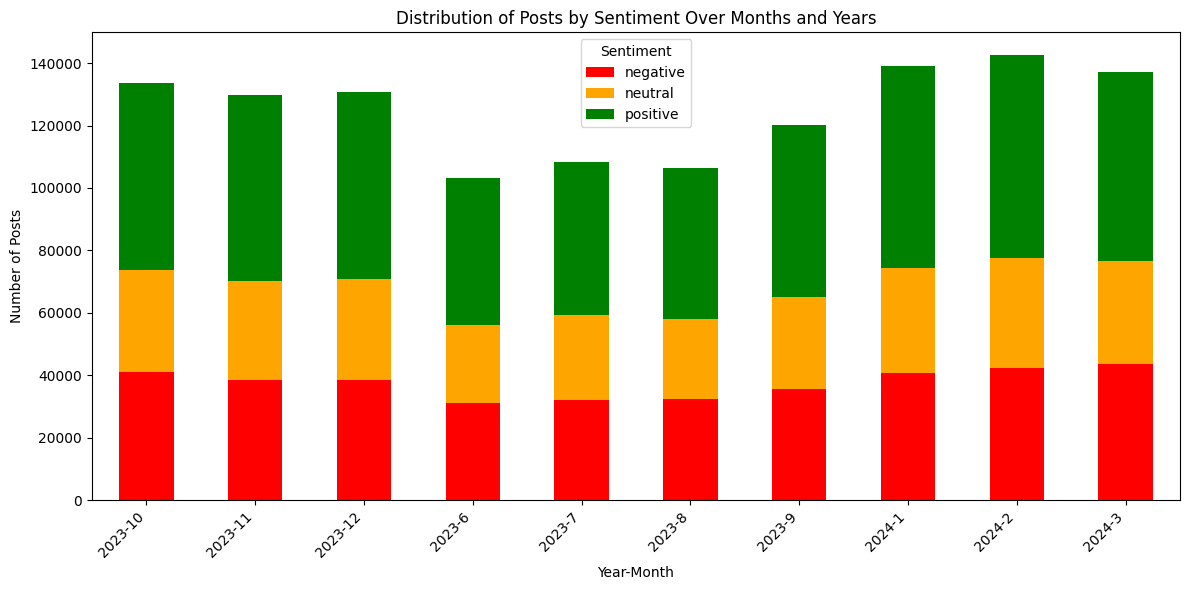

In [79]:
# Concatenate year and month into a new column for easier grouping
Stemm_lemm_comments_df = Stemm_lemm_comments_df.withColumn("year_month", concat_ws("-", col("year"), col("month")))

# Group by 'year_month' and 'sentiment', and count the number of posts
sentiment_counts = Stemm_lemm_comments_df.groupBy("year_month", "sentiment").count()

# Convert the DataFrame to Pandas for plotting
sentiment_counts_pandas = sentiment_counts.toPandas()

# Pivot the data for plotting
sentiment_pivot = sentiment_counts_pandas.pivot(index='year_month', columns='sentiment', values='count')
sentiment_pivot = sentiment_pivot.fillna(0)  # Fill NA values with 0

# Define custom colors for each sentiment
senti_colors = {'positive': 'green', 'negative': 'red', 'neutral': 'orange'}

# Plotting stacked bar chart with custom colors
ax = sentiment_pivot.plot(kind='bar', stacked=True, figsize=(12, 6), color=[senti_colors.get(x, '#333333') for x in sentiment_pivot.columns])
plt.title('Distribution of Comments by Sentiment Over Months and Years')
plt.xlabel('Year-Month')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Sentiment', labels=sentiment_pivot.columns)
plt.tight_layout()
plt.show()


In [80]:
# Group by 'year', 'month', and 'sentiment' and count rows
# Pivot to transform sentiments into separate columns with counts
post_volume_over_time_sentiment = Stemm_lemm_comments_df.groupBy("year", "month")\
    .pivot("sentiment")\
    .count()

# Fill null values with zero after pivoting
post_volume_over_time_sentiment = post_volume_over_time_sentiment.na.fill(0)

# Displaying the DataFrame in a tabular format
print("Tabular summary of comments volume by sentiment over time:\n")
post_volume_over_time_sentiment.show(truncate=False)


Tabular summary of post volume by sentiment over time:



+----+-----+--------+-------+--------+
|year|month|negative|neutral|positive|
+----+-----+--------+-------+--------+
|2023|8    |32493   |25477  |48563   |
|2023|9    |35724   |29433  |54894   |
|2024|3    |43646   |32973  |60687   |
|2023|7    |32215   |27163  |48989   |
|2023|6    |30962   |25218  |47060   |
|2024|2    |42177   |35296  |65258   |
|2023|11   |38330   |31751  |59585   |
|2024|1    |40827   |33521  |64755   |
|2023|10   |40892   |32810  |59846   |
|2023|12   |38632   |32240  |59817   |
+----+-----+--------+-------+--------+



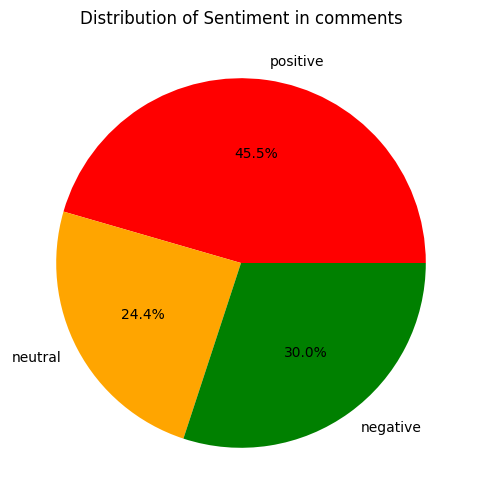

In [81]:
# Aggregate the count of each sentiment
sentiment_counts_df = Stemm_lemm_comments_df.groupBy("sentiment").count()

# Collect the data to the driver as a Pandas DataFrame
sentiment_counts_pandas = sentiment_counts_df.toPandas().set_index("sentiment")

# Defining custom colors for each sentiment, ensuring order by matching the index
senti_colors = ['red', 'orange', 'green']  # Order needs to match with the sentiment_counts_pandas index if specific
senti_labels = sentiment_counts_pandas.index  # This will fetch labels in the order they are stored

plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts_pandas['count'], labels=senti_labels, autopct='%1.1f%%', colors=senti_colors)
plt.title('Distribution of Sentiment in Comments')
plt.show()


## Upload clean files to GCS Bucket

In [82]:
# Function to upload files to GCS
def upload_files_to_gcs(bucket_name, source_file_path, destination_blob_path):
    """
    Uploads a file to the bucket.
    """
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_path)
    blob.upload_from_filename(source_file_path)
    print(f"Uploaded {source_file_path} to gs://{bucket_name}")


# Define GCS bucket and blob prefix
bucket_name = 'cleaned_data_reddit'
blob_prefix = f'processed_data_{today}/'

# Upload files to GCS
upload_files_to_gcs(bucket_name, 'comments_clean_final.csv', blob_prefix + 'comments_clean_final.csv')
upload_files_to_gcs(bucket_name, 'posts_clean_final.csv', blob_prefix + 'posts_clean_final.csv')

In [83]:
spark.stop()